<a href="https://colab.research.google.com/github/Saanimustapha/AbaloneAgePrediction/blob/main/Group15_RandomForestRegression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error


In [ ]:
data = pd.read_csv('abalone.csv')

In [ ]:
#Handling out;iers with capping method.
numeric_cols = data.select_dtypes(include=[np.number]).columns

factor = 1.5

for col in numeric_cols:
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - factor * IQR
    upper_bound = Q3 + factor * IQR
    data[col] = np.clip(data[col], lower_bound, upper_bound)

In [ ]:
data_encoded = pd.get_dummies(data, columns=['sex'])

X = data_encoded.drop(columns=[' rings'])
y = data_encoded[' rings']

# Step 3: Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Step 4: Define Pipeline and Parameter Grid
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Include a scaler if needed
    ('rf', RandomForestRegressor())
])

param_grid = {
    'rf__n_estimators': [100, 200, 300],  # Number of trees in the forest
    'rf__max_depth': [None, 10, 20, 30],  # Maximum depth of each tree
    'rf__min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'rf__min_samples_leaf': [1, 2, 4],    # Minimum number of samples required to be at a leaf node
    'rf__max_features': ['auto', 'sqrt', 'log2']  # Number of features to consider when looking for the best split
}

# Step 5: Perform Grid Search with Cross-Validation
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Print best parameters and model performance
print(f'Best parameters: {grid_search.best_params_}')

# Step 6: Evaluate Model Performance
best_pipeline = grid_search.best_estimator_
y_pred = best_pipeline.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error on test set: {rmse}')

# Optional: Print feature importances if needed
if 'rf' in best_pipeline.named_steps:
    feature_importances = best_pipeline.named_steps['rf'].feature_importances_
    print('Feature Importances:')
    for feature, importance in zip(X.columns, feature_importances):
        print(f'{feature}: {importance}')

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors

Best parameters: {'rf__max_depth': None, 'rf__max_features': 'log2', 'rf__min_samples_leaf': 4, 'rf__min_samples_split': 2, 'rf__n_estimators': 300}
Root Mean Squared Error on test set: 1.705904391218335
Feature Importances:
 length: 0.08349029049913358
 diameter: 0.09335788991594403
 height: 0.1113622207352057
 whole_weight: 0.14921875833367634
 shucked_weight: 0.12249199765280894
 viscera_weight: 0.11107205184463464
 shell_weight: 0.2903066399589665
sex_F: 0.008894284798412892
sex_I: 0.02229341865678261
sex_M: 0.007512447604434789


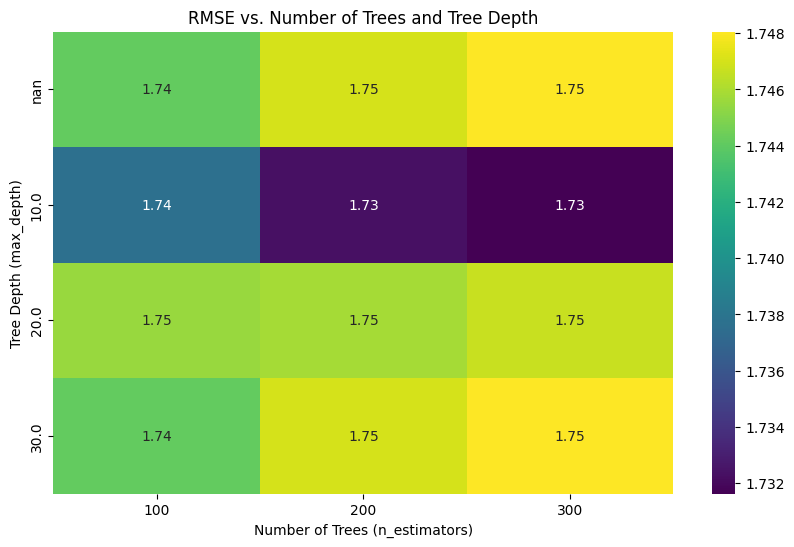

In [ ]:
n_estimators_range = [100, 200, 300]
max_depth_range = [None, 10, 20, 30]

# Prepare a DataFrame to store the results
results = []

# Perform manual grid search
for n_estimators in n_estimators_range:
    for max_depth in max_depth_range:
        pipeline = Pipeline([
            ('scaler', StandardScaler()),  # Include a scaler if needed
            ('rf', RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=0))
        ])
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        results.append((n_estimators, max_depth, rmse))

# Convert results to DataFrame
results_df = pd.DataFrame(results, columns=['n_estimators', 'max_depth', 'rmse'])



pivot_table = results_df.pivot(index='max_depth', columns='n_estimators', values='rmse')

# Plot the heatmap
plt.figure(figsize=(10, 6))
plt.title('RMSE vs. Number of Trees and Tree Depth')
sns.heatmap(pivot_table, annot=True, fmt=".2f", cmap="viridis")
plt.xlabel('Number of Trees (n_estimators)')
plt.ylabel('Tree Depth (max_depth)')
plt.show()